# **Case 2: Text Classification using Large Language Model (using RoBERTa)**

Name: Felicia Ferren

NIM: 2440013071

Video link: https://youtu.be/9gAuTkfC50M

### **Import Google Drive to colab**

 The data will be accessed from here.

In [ ]:
# import drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# view files
! ls

drive  sample_data


In [ ]:
# setting project directory
%cd drive/My Drive/uas-text-mining

/content/drive/.shortcut-targets-by-id/17_YgSKIOhK4PGF8Wqf_24NDQ3BGKkPZA/uas-text-mining


We need to install ```transformers``` to build the model.

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.2 MB/s eta 0:00:00


## Load Data

Now, we load the data 'data_1B.csv' and let's see what's in there... (the process done here is the same as we did on the first case)

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# read data
df = pd.read_csv('data_1B.csv')

df.head(5)

,Unnamed: 0,text,label
0,0,AV2 Women Maternity Wear/Feedind/Nursing Top &...,Clothing & Accessories
1,1,Houskipper Professional Spray Mop with Best 36...,Household
2,2,"Tat-Sat Ceramic Fondue Burner , Black This Fon...",Household
3,3,"Prestige Plastic Hand Blender, Orange Save tim...",Household
4,4,Gorilla Renesa+ Energy Saving 5 Star Rated Cei...,Household


we can see here that maybe this Unnamed: 0 field is just the index of our observations, so we can just remove them.

In [ ]:
# drop out the first field, we will only take text and label field
df1 = df.iloc[:, 1:].copy()

df1.head(5)

,text,label
0,AV2 Women Maternity Wear/Feedind/Nursing Top &...,Clothing & Accessories
1,Houskipper Professional Spray Mop with Best 36...,Household
2,"Tat-Sat Ceramic Fondue Burner , Black This Fon...",Household
3,"Prestige Plastic Hand Blender, Orange Save tim...",Household
4,Gorilla Renesa+ Energy Saving 5 Star Rated Cei...,Household


now, we have a dataframe with 2 variables, which are 'text' and 'label'. The 'text' is the sentences and they are classified into a label in 'label' field. Let's find out more in EDA!

## Exploratory Data Analysis

Now, we will gather more information about our dataset in this section. (the process done here is the same as we did on the first case)

In [ ]:
# view shape
df1.shape

(12606, 2)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12606 entries, 0 to 12605
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12606 non-null  object
 1   label   12606 non-null  object
dtypes: object(2)
memory usage: 197.1+ KB


Here, we can tell that there are 12606 observations in our dataset where there is likely no NULL values.

Now, we will check the count of the text's label and see the distributions.

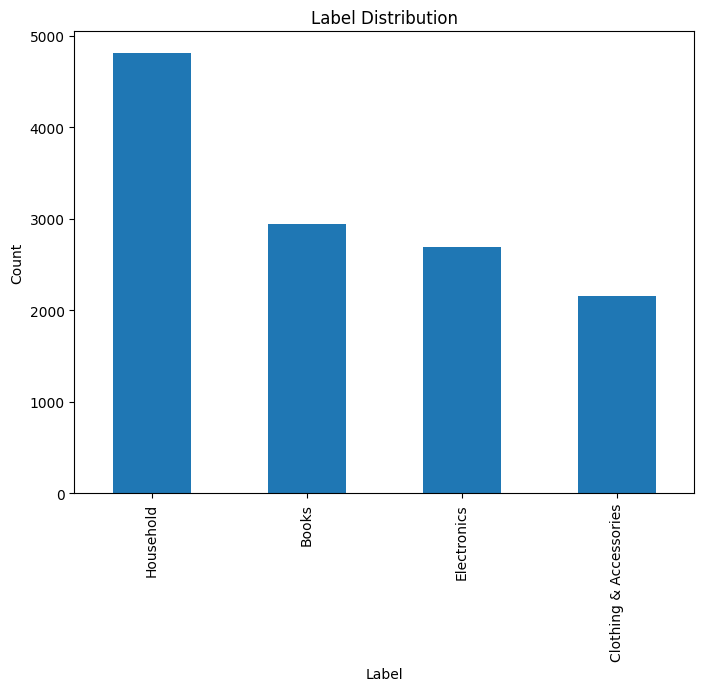

In [ ]:
# check the count of text label
label_counts = df1['label'].value_counts()

# plot into bar chart
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# see the distribution of the text label in numbers
label_counts

Household                 4810
Books                     2946
Electronics               2693
Clothing & Accessories    2157
Name: label, dtype: int64

We can see here that the class is imbalanced, where most texts classified as 'Household' (around 40%, while the other are around 20%).

Hence, we will use this information later for modeling.

Now, let's see several samples of records..

In [ ]:
# preview several samples of records
print('Text: \n', df1['text'].iloc[500])
print('Label: \n', df1['label'].iloc[500])
print('\n')
print('Text: \n', df1['text'].iloc[5000])
print('Label: \n', df1['label'].iloc[5000])

Text: 
 Alexvyan Universal World Travel Power Plug, European Adapter, AC Outlet Plugs for All Countries (White) - Pack of 2 Size name:Pack of 2   Stop carrying multiple adapters and make travelling convenient with this SmartPro all-in-one world travel adapter. Compact and a lightweight, this power adapter makes a perfect travel companion wherever you go. It is compatible with Australian, UK, Spain, US, and Japanese style plugs, making it one of the most useful and versatile plug adapters. In short, it is designed to suit the power plugs used in over 150 different countries, so you just don’t need to worry about connectivity issues when you travel abroad. This travel adapter also has a built-in surge protector to prevent power fluctuations from harming your charging gadgets. The child protection safety shutter incorporated in this adapter comes in handy in places where the power outlets are within the reach of kids. Its power indicator light lets you know if the plug is turned on/off an

We can see here that we might need some cleaning, such as making the characters into lowercase, remover punctuations, etc. This will be done in the next process, pre-processing process.

Then, we want to know the distribution of our text length in order to set the max_length in the modelling process.

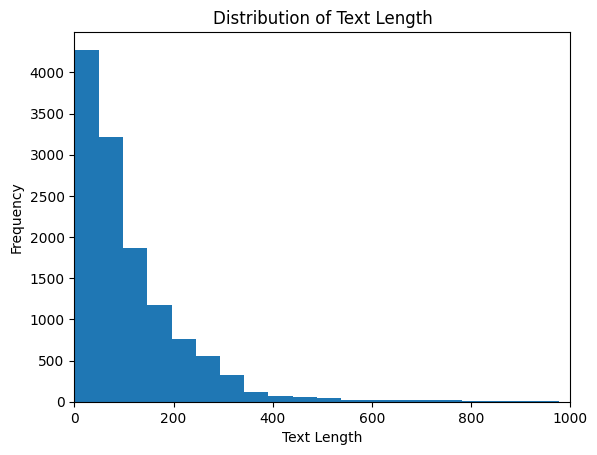

In [ ]:
# find out the distribution of text length
df1['length'] = df1['text'].apply(lambda x: len(x.split()))

plt.hist(df1['length'], bins=120)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.xlim(0, 1000)
plt.show()

From the plot above, we can tell that our texts are centered to lower text length. Most samples have around under 200 words in it. If we look at the graph thoroughly, we can see there is a bit sample having more than 400 text length, that might considered as outliers (out of the majority of our data).

Hence, later in the modelling, **we will take the max_length of 256** because  it's approximate boundary for our data text, where we can have most of the observations below the limit (and only a few that exceed the limit). We have to set the parameter max_length because RoBERTa model has limitation on the maximum length of input sequence they can handle. So, if the input sequence exceed that length, it needs to be truncated or shortened to fit the model's requirement. On the other side, the ones which shorter than max_length will be padded until matching the maximum length.

Setting the appropiate max_length value is important, because we want to balance the trade-off between retaining important information in longer sequences and managing computational resources and model memory.

## Pre-Processing Process

In the preprocessing process, we will clean the data by removing URLs, remove punctuation, and convert to lowercase. Then, we will do tokenization and remove the stopwords inside the texts. Lastly, we do lemmatization to get the data into the normal (lemma) form and bring back into string. **In the modelling process, we will be using pre-trained model from RoBERTa (A Robustly Optimized BERT Pretraining Approach)**. Although RoBERTA already includes tokenization and vectorization, we did the same pre-processing process to match the pre-processing on the first case.

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# define pre-processing functions
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # remove URLs
    text = text.translate(str.maketrans("", "", string.punctuation)) # remove punctuation
    text = text.lower() #convert to lowercase

    # tokenization
    tokens = nltk.word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens] # also remove gerund or +ing into verb (base word)

    # join back token into string
    preprocessed_text = " ".join(tokens)

    return preprocessed_text

Here, we joined the tokens back into string because the RoBERTa takes the string format and will do the tokenization along with vectorization (inside the pre-trained model).

Then, we try applying the pre-process function into the text data and see the sample results!

In [ ]:
# apply the pre-processing process into the text data
df1['clean_text'] = df1['text'].apply(preprocess_text)

In [ ]:
print('Text: \n', df1['text'].iloc[500])
print('Cleaned Text: \n', df1['clean_text'].iloc[500])
print('Label: \n', df1['label'].iloc[500])
print('\n')
print('Text: \n', df1['text'].iloc[5000])
print('Cleaned Text: \n', df1['clean_text'].iloc[5000])
print('Label: \n', df1['label'].iloc[5000])

Text: 
 Alexvyan Universal World Travel Power Plug, European Adapter, AC Outlet Plugs for All Countries (White) - Pack of 2 Size name:Pack of 2   Stop carrying multiple adapters and make travelling convenient with this SmartPro all-in-one world travel adapter. Compact and a lightweight, this power adapter makes a perfect travel companion wherever you go. It is compatible with Australian, UK, Spain, US, and Japanese style plugs, making it one of the most useful and versatile plug adapters. In short, it is designed to suit the power plugs used in over 150 different countries, so you just don’t need to worry about connectivity issues when you travel abroad. This travel adapter also has a built-in surge protector to prevent power fluctuations from harming your charging gadgets. The child protection safety shutter incorporated in this adapter comes in handy in places where the power outlets are within the reach of kids. Its power indicator light lets you know if the plug is turned on/off an

Here, we can see that the data has successfully cleaned.

Now, we tried to define several configuration needed for the next processes..

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm import tqdm

In [ ]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42 # random seed = 42; for reproducibility
        self.MODEL_PATH = 'roberta-base' # the pretrained model
        self.NUM_CLASSES = 4 # number of classes in our dataset

        self.LABELS = {'Household':0,
          'Books':1,
          'Electronics':2,
          'Clothing & Accessories':3
          }

        # data
        self.TOKENIZER = RobertaTokenizer.from_pretrained(self.MODEL_PATH) # using tokenizer from pretrained model
        self.MAX_LENGTH = 256 # the max length (already explained)
        self.BATCH_SIZE = 16 # number of batch size, where the data will be inputted into batch with this number of data in each batch
        self.TEST_SPLIT = 0.20 # for train-test splitting
        self.VAL_SPLIT = 0.50 # for test-validation splitting

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use cuda if available
        self.LR = 2e-5 # learning rate = 2.10^-5 = 0.00002
        self.OPTIMIZER = 'AdamW' # optimizer = AdamW
        self.CRITERION = 'CrossEntropyLoss' # criterion = CrossEntropyLoss
        self.EPOCHS = 3 # number of epoch(s) for training process

config = Config()



In this model, we will be using the tokenizer from pretrained model. We use the pretrained model roberta-base.

Hence, we will do fine-tuning from the pretrained model where the model will be trained on specific task. Before that, we use 8:1:1 train-test-validation split from the full dataset.

We use AdamW (Adam with Weight Decay) optimizer. This optimizer applies weight decay to the parameters during the parameter update step. This helps prevent overfitting and improves the generalization of the model.

We also use CrossEntropyLoss (Cross-Entropy Loss) as our loss function, where this function is suitable for multiclass problem.

The labels will be formatted into numbers, where 'Household':0, 'Books':1, 'Electronics':2, 'Clothing & Accessories':3.

There are hyperparameter we use for the modelling, like learning rate = 2.10^-5. we also use 3 epochs.

Then, we create Dataset class to create a PyTorch dataset object that can be used for training, validation, or testing process later.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data): # intializations; takes data arguments
        self.labels = [config.LABELS[label] for label in data['label']]
        self.texts = data['clean_text'].values
        self.tokenizer = config.TOKENIZER
        self.max_length = config.MAX_LENGTH

    def __len__(self):
        return len(self.labels) # return length of labels

    def __getitem__(self, idx):
        # fetch text and label corresponding to the index
        text = self.texts[idx]
        label = self.labels[idx]

        # encode the text using tokenizer.encode_plus method
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length, # maximum of the sequence length
            padding='max_length', # pads the input shorter than the max_length into the max_length
            truncation=True, # perform truncation to text with length longer than max_length
            return_tensors='pt'
        )

        # returned as tensor
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label)
        }

Then, we start doing the splitting process. The ratio is 8:1:1 for train-test-validation set. The dataset will be splitted by paying attention to the 'label' classes, so there wont be imbalanced split.

In [ ]:
# train-test-val split
# split the dataset into train, test, and validation set. we are using 8:1:1 train-test-val ratio.
from sklearn.model_selection import train_test_split

np.random.seed(config.SEED)
# Splitting into train and remaining data (validation + test)
df_train, df_remaining = train_test_split(df1, test_size=config.TEST_SPLIT, stratify=df1['label'], random_state=42)

# Splitting the remaining data into validation and test
df_val, df_test = train_test_split(df_remaining, test_size=config.VAL_SPLIT, stratify=df_remaining['label'], random_state=42)

print(len(df_train), len(df_val), len(df_test))

10084 1261 1261


Then, we perform the pytorch object creation using the Dataset class, and sent it to dataloader.

In [ ]:
train_data = Dataset(df_train)
val_data = Dataset(df_val)

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 256])
attention_mask shape: torch.Size([16, 256])
labels shape: torch.Size([16])


## **Building Model**

Now, we will start the modelling process by defining the Model from pre-trained model.

In [ ]:
from torch import nn
from transformers import RobertaModel

class RoBERTaClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        # initialize the model
        super(RoBERTaClassifier, self).__init__()

        self.roberta = RobertaModel.from_pretrained(config.MODEL_PATH) # loads pretrained model
        self.dropout = nn.Dropout(dropout) # do droput regularization with dropout = 0.3 (prevent overfitting)
        self.linear = nn.Linear(768, config.NUM_CLASSES) # maps the output to the number of classes
        self.relu = nn.ReLU() # do ReLU activation function (self.relu) to introduce non-linearity.

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        o2 = outputs[1]
        dropout_output = self.dropout(o2)
        linear_output = self.linear(dropout_output)
        final_output = self.relu(linear_output)

        return final_output

In [ ]:
# specify the device using cuda
device = config.DEVICE
device

device(type='cuda')

Then, we define the training and validation process here below:

In [ ]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs):
    torch.manual_seed(config.SEED) # set seed
    use_cuda = torch.cuda.is_available() # make sure cude is available to use
    device = torch.device("cuda" if use_cuda else "cpu")

    # define loss function and optimizer (along with specified learning rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # move the model and the loss function to the appropriate device
    model.to(device)
    criterion.to(device)

    # initialize the best validation loss to a very high value
    best_val_loss = float('inf')

    # start the training loop for the specified number of epochs
    for epoch_num in range(epochs):
        # initialize variables to keep track of total accuracy and loss during training
        total_acc_train = 0
        total_loss_train = 0

        # set the model to train mode
        model.train()
        for batch in tqdm(train_dataloader):
            # unpack the batch contents and push them to the device (cuda or cpu).
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # zero-ing the gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(input_ids, attention_mask)

            # compute loss
            loss = criterion(outputs, labels)
            # backward pass and optimization step
            loss.backward()
            optimizer.step()

            # update the total loss and current accuracy for the current batch
            total_loss_train += loss.item()
            total_acc_train += (outputs.argmax(dim=1) == labels).sum().item()

        # initialize variables to keep track of total accuracy and loss during validation
        total_acc_val = 0
        total_loss_val = 0

        # Set the model to evaluation mode
        model.eval()
        # disable gradient calculation for validation
        with torch.no_grad():
            # iterate over validation data
            for batch in val_dataloader:
                # unpack the batch contents and push them to the device (cuda or cpu)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # forward pass
                outputs = model(input_ids, attention_mask)

                # compute loss between outputs labels
                loss = criterion(outputs, labels)

                # update the total loss and accuracy for the current batch
                total_loss_val += loss.item()
                total_acc_val += (outputs.argmax(dim=1) == labels).sum().item()

        # compute the average training and validation loss and accuracy
        train_loss_avg = total_loss_train / len(train_dataloader.dataset)
        train_acc_avg = total_acc_train / len(train_dataloader.dataset)
        val_loss_avg = total_loss_val / len(val_dataloader.dataset)
        val_acc_avg = total_acc_val / len(val_dataloader.dataset)

        # print the average losses and accuracies for the epoch
        print(f'Epochs: {epoch_num + 1} | Train Loss: {train_loss_avg:.6f} | Train Accuracy: {train_acc_avg:.6f} '
              f'| Val Loss: {val_loss_avg:.6f} | Val Accuracy: {val_acc_avg:.6f}')

        # save the model if the current validation loss is better than the previous best
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"Saved model with val loss: {best_val_loss:.3f} as best_model.pt")

In [ ]:
# initialize the model
model = RoBERTaClassifier()
model.to(device);

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# do the training and validation process
train(model, train_dataloader, val_dataloader, config.LR, config.EPOCHS)

100%|██████████| 631/631 [07:31<00:00,  1.40it/s]


Epochs: 1 | Train Loss: 0.020918 | Train Accuracy: 0.896767 | Val Loss: 0.011790 | Val Accuracy: 0.955591
Saved model with val loss: 0.012 as best_model.pt


100%|██████████| 631/631 [07:27<00:00,  1.41it/s]


Epochs: 2 | Train Loss: 0.010230 | Train Accuracy: 0.956962 | Val Loss: 0.010719 | Val Accuracy: 0.959556
Saved model with val loss: 0.011 as best_model.pt


100%|██████████| 631/631 [07:27<00:00,  1.41it/s]


Epochs: 3 | Train Loss: 0.007589 | Train Accuracy: 0.968862 | Val Loss: 0.009960 | Val Accuracy: 0.965107
Saved model with val loss: 0.010 as best_model.pt


From this result, we get that the train and validation loss is considered already small on epoch 1 (meaning it's a great result!). Both training and validation loss also keeps lowering over 3 epochs, resulting in getting higher train and validation accuracy over epochs. We are getting 96.88% train accuracy and 96.51% validation accuracy which is very great result!

Next, we will do the hyperparameter tuning to check other hyperparameters that might be resulting better results than our current model result. But, please keep in mind that comparing training and validation loss alone is not sufficient to evaluate the model's performance -- where we will see at the evaluation.

## Hyperparameter Tuning

### Build model for tuning

For tuning process, we will be using `optuna` as our hyperparameter optimization framework. The hyperparameter we will tune are:
- dropout: 0.3 or 0.5
- learning rate: 1e-6 until 1e-2
- optimizer: Adam, AdamW, RMSProp

to save time and computation resources, we will only do 3 trials for this tuning process and each of them will be tuned for 1 epoch (I've tried using 3 epochs for each trial, but got OutOfMemory Error).

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
import optuna
from torch.optim import Adam, RMSprop

In [ ]:
# re-define the model because we have 2 dropout options ([0.3, 0.5])
class RoBERTaClassifier_tune(nn.Module):
    def __init__(self, dropout):
        super(RoBERTaClassifier_tune, self).__init__()

        self.roberta = RobertaModel.from_pretrained(config.MODEL_PATH)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, config.NUM_CLASSES)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        o2 = outputs[1]
        dropout_output = self.dropout(o2)
        linear_output = self.linear(dropout_output)
        final_output = self.relu(linear_output)

        return final_output

In [ ]:
# define objective function for Optuna optimization
def objective(trial):
    # random seeding
    torch.manual_seed(config.SEED)

    # check gpu availability
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # sampling the dropout rate, learning rate, and optimizer name using Optuna suggestions
    dropout = trial.suggest_categorical('dropout', [0.3, 0.5])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'adamW', 'rmsprop'])

    # create a new instance
    model = RoBERTaClassifier_tune(dropout=dropout)

    # define loss function
    criterion = nn.CrossEntropyLoss()

    # select optimizer based on sampled optimizer name
    if optimizer_name == 'adam':
        optimizer = Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'adamW':
        optimizer = AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(model.parameters(), lr=learning_rate)

    # move model and loss function to the appropriate device
    model.to(device)
    criterion.to(device)

    # initialize best validation loss to a very high value
    best_val_loss = float('inf')

    # start the training loop for a fixed number of epochs (1 in this case)
    for epoch_num in range(1):
        # initialize variables to keep track of total accuracy and loss during training
        total_acc_train = 0
        total_loss_train = 0

        # set the model to train mode
        model.train()

        # iterate over the training data
        for batch in tqdm(train_dataloader):
            # move the input IDs, attention mask, and labels to the device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # zero-ing the gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(input_ids, attention_mask)

            # compute loss between outputs and labels
            loss = criterion(outputs, labels)

            # backward pass and optimization step
            loss.backward()
            optimizer.step()

            # update the total loss and accuracy for the current batch
            total_loss_train += loss.item()
            total_acc_train += (outputs.argmax(dim=1) == labels).sum().item()

        # initialize variables to keep track of total accuracy and loss during validation
        total_acc_val = 0
        total_loss_val = 0

        # set the model to evaluation mode
        model.eval()

        # disable gradient calculation for validation
        with torch.no_grad():
            # iterate over the validation data
            for batch in val_dataloader:
                # move the input IDs, attention mask, and labels to the device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # forward pass
                outputs = model(input_ids, attention_mask)

                # compute loss between outputs and labels
                loss = criterion(outputs, labels)

                # update total loss and accuracy for the current batch
                total_loss_val += loss.item()
                total_acc_val += (outputs.argmax(dim=1) == labels).sum().item()

        # compute the average training and validation loss and accuracy
        train_loss_avg = total_loss_train / len(train_dataloader.dataset)
        train_acc_avg = total_acc_train / len(train_dataloader.dataset)
        val_loss_avg = total_loss_val / len(val_dataloader.dataset)
        val_acc_avg = total_acc_val / len(val_dataloader.dataset)

        # print the average losses and accuracies for the epoch
        print(f'Epochs: {epoch_num + 1} | Train Loss: {train_loss_avg:.6f} | Train Accuracy: {train_acc_avg:.6f} '
              f'| Val Loss: {val_loss_avg:.6f} | Val Accuracy: {val_acc_avg:.6f}')

    return val_acc_avg  # Return the validation accuracy as the objective value

### Model Tuning

In [ ]:
# do the hyperparamter tuning for 3 trials
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

# get the best trial & best parameters out of the study
best_trial = study.best_trial
best_params = best_trial.params

[I 2023-07-08 15:00:42,318] A new study created in memory with name: no-name-445e6dbf-995a-40a5-90c4-33a80dfbee75
<ipython-input-32-334d4885a252>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly iden

Epochs: 1 | Train Loss: 0.087925 | Train Accuracy: 0.381396 | Val Loss: 0.086850 | Val Accuracy: 0.381443


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 631/631 [07:08<

Epochs: 1 | Train Loss: 0.086717 | Train Accuracy: 0.381198 | Val Loss: 0.086850 | Val Accuracy: 0.381443


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 631/631 [07:08<

Epochs: 1 | Train Loss: 0.084995 | Train Accuracy: 0.381694 | Val Loss: 0.086850 | Val Accuracy: 0.381443


Now, let's see the best hyperparameters from the tuning process, and compare the results from tuning and our base model results.

In [ ]:
print('Best Trial:')
print('\tValidation accuracy: ', best_trial.value)
print('\tParams: ')
for key, value in best_params.items():
    print("\t   {}: {}".format(key, value))

Best Trial:
	Validation accuracy:  0.38144329896907214
	Params: 
	   dropout: 0.3
	   learning_rate: 0.0038839563432664145
	   optimizer: rmsprop


### Summary of Tuning Process:

#### **Our Base Model:**
> dropout=0.3
>
> LR = 2e-5
>
> optimizer = AdamW

**Epoch 1 Result:**

Epochs: 1 | Train Loss: 0.020918 | Train Accuracy: 0.896767 | Val Loss: 0.011790 | Val Accuracy: 0.955591

------------------------------------------

#### **Best Trial:**

> dropout=0.3
>
> LR = 0.0038839563432664145
>
> optimizer = rmsprop

**Epoch 1 Result:**

Epochs: 1 | Train Loss: 0.087925 | Train Accuracy: 0.381396 | Val Loss: 0.086850 | Val Accuracy: 0.381443

---------------------------------------------



The best trial uses different optimizer and learning rate from our base model, and resulting a very bad train & validation loss and accuracy. This means our base model is already has the best optimizer. The learning rate here is way bigger than the learning rate we used in our base model.

Although the loss values are quite close between the tuned and base model, the accuracy here showed a very different result.

We also can see that validation loss is lower than the loss in training on both model, meaning both model generalize well to unseen data. A lower validation loss indicates that the model performs well on the validation set, which consists of data that the model hasn't seen during training. This means that both models are not overfitting to the training data. Comparing training and validation loss alone is not sufficient to evaluate the model's performance.

The result of our base model is way better, and the loss is also decreasing on the next epoch.

**In conclusion, we will use the base model for as our final model.**

## Evaluation

Now, we will evaluate our model using the test set.

In [ ]:
# call the final model for testing process
best_model = RoBERTaClassifier()  # Create an instance of the model
best_model.load_state_dict(torch.load('best_model.pt'))  # Load the final model
best_model.to(device)  # Move the model to the appropriate device (CPU or GPU)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
test_data = Dataset(df_test)
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE, shuffle=False)

In [ ]:
len(test_data) # just to make sure the data length is correct

1261

For this evaluation, we will use classification report and confusion matrix.

In [ ]:
# import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# define the evaluation process
def evaluate(model, test_dataloader):
    # set the model into evaluation mode
    model.eval()

    # initialize empty lists for predictions and labels
    predictions = []
    labels = []

    # disable gradient calculation for evaluation
    with torch.no_grad():
        # Iterate over the test data
        for batch in test_dataloader:
            # Move the input IDs and attention mask to the device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels']

            # forward pass
            outputs = model(input_ids, attention_mask)

            # compute predictions and append to the list
            batch_predictions = outputs.argmax(dim=1).cpu().numpy()
            predictions.extend(batch_predictions)

            # append the true labels to the list
            labels.extend(batch_labels)

    # convert the predictions and labels to NumPy arrays
    predictions = np.array(predictions)
    labels = np.array(labels)

    # compute evaluation metrics
    accuracy = (predictions == labels).mean()
    class_report = classification_report(labels, predictions)
    cm = confusion_matrix(labels, predictions)

    # print evaluation metrics
    print(f"Accuracy: {accuracy:.6f}")
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(cm)

    return accuracy, class_report, cm

In [ ]:
# run the evaluation
accuracy, class_report, cm = evaluate(best_model, test_dataloader)

Accuracy: 0.963521
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       481
           1       0.97      0.95      0.96       295
           2       0.96      0.95      0.95       269
           3       0.97      0.98      0.97       216

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

Confusion Matrix:
[[467   4   8   2]
 [ 10 281   3   1]
 [  6   4 256   3]
 [  3   1   1 211]]


## Summary

In this summary, we will gather insights from the model evaluation.

We recall the results from the report from the first case, where we use machine learning to classify the classes (using Support Vector Machine Classifier along with TF-IDF Vectorizer):

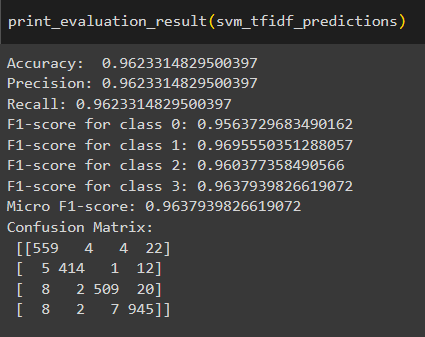


Comparing to the first solving, we can tell that **this case can be handled very well only by using simple Machine Learning** -- here, we have a very similar results among the metrics.

Now, by comparing this results to the training result, **we can see that the test accuracy is already close to the validation accuracy, meaning there is no overfitting.**

We also can tell that the **f1-score for each labels from the LLM Model Evaluation has higher score than the ones from ML model**. This higher f1-score means there are less missclassified class on each labels on the LLM Model than on the ML Model. Our LLM Model still resulting a slightly better classification on the test data.



*note: the portion of test case on ML model is larger (20% out of full dataset) rather than on the LLM (only 10% out of full dataset).